In [1]:
import pandas as pd

df = pd.read_excel('elife-16965-supp1-v4.xlsx')
print(len(df))
df.head()

149361


,Variants,HD,Count input,Count selected,Fitness
0,VDGV,0,92735,338346,1.000000
1,ADGV,1,34,43,0.061910
2,CDGV,1,850,641,0.242237
3,DDGV,1,63,63,0.006472
4,EDGV,1,841,190,0.032719


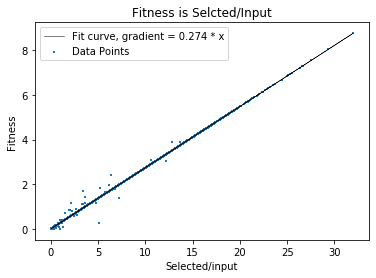

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def line(x,y):
    return x*y

gradient, covariance = curve_fit(line, df['Count selected']/df['Count input'], df['Fitness'])

plt.plot(df['Count selected']/df['Count input'],
         (df['Count selected']/df['Count input']).apply(line, args = (gradient)),
        c = 'black', lw = 0.5)
plt.scatter(df['Count selected']/df['Count input'], df['Fitness'], s=5, marker = '+')
plt.title('Fitness is Selcted/Input')
plt.xlabel('Selected/input')
plt.ylabel('Fitness')
plt.legend([f'Fit curve, gradient = {round(gradient[0],3)} * x', 'Data Points'])
plt.show()

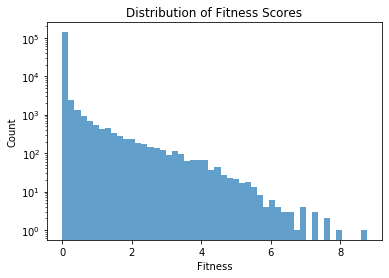

In [3]:
plt.hist(df['Fitness'], bins = 50, alpha = 0.7)
plt.title('Distribution of Fitness Scores')
plt.ylabel('Count')
plt.xlabel('Fitness')
plt.yscale('log')
plt.show()

In [4]:
import numpy as np

def ohe(seq):
    # one hot encoder - 1D
    aas = dict(zip(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], range(20)))
    ohe = []
    for i in seq:
        tmp = np.zeros(20)
        idx = aas[i]
        tmp[idx] = 1
        ohe.append(tmp)
    ohe = np.concatenate(ohe)
    return pd.Series(ohe)

sequences_ohe = df['Variants'].apply(ohe)
sequences_ohe.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


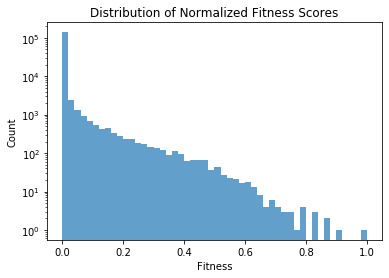

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

fitness = scaler.fit_transform(df[['Fitness']])

plt.hist(fitness, bins = 50, alpha = 0.7)
plt.title('Distribution of Normalized Fitness Scores')
plt.ylabel('Count')
plt.xlabel('Fitness')
plt.yscale('log')
plt.show()

In [25]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(80,8)
        self.layer2 = nn.Linear(8,1)
    def forward(self,x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.sigmoid(x)
        return x

net = Net()

In [26]:
from torch.utils.data import Dataset, DataLoader, random_split

class TorchFmtDataset(Dataset):
    def __init__(self,x,y):
        super(Dataset, self).__init__()
        self.x = torch.from_numpy(x.values.astype(float))
        self.y = torch.from_numpy(y.astype(float))
        
    def __getitem__(self,index):
        return self.x[index].float(), self.y[index].float()
    
    def __len__(self):
        return len(self.x)
        
torch_fmt_dataset = TorchFmtDataset(sequences_ohe, fitness)

test_size = int(len(torch_fmt_dataset)*0.5)

train_size = len(torch_fmt_dataset) - test_size

train_data, test_data = random_split(torch_fmt_dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=16)

test_loader = DataLoader(test_data, batch_size=16)

x_batch, y_batch = next(iter(train_loader))

net(x_batch)

tensor([[0.4824],
        [0.4989],
        [0.4847],
        [0.5160],
        [0.4855],
        [0.4896],
        [0.4863],
        [0.5038],
        [0.4952],
        [0.4889],
        [0.4815],
        [0.4804],
        [0.4479],
        [0.4692],
        [0.5104],
        [0.5058]], grad_fn=<SigmoidBackward>)

100%|██████████| 4668/4668 [00:05<00:00, 873.45it/s] 


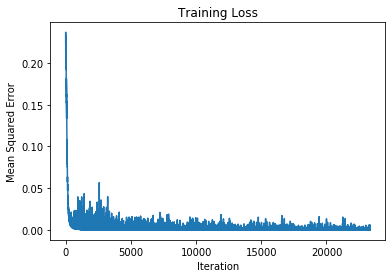

In [27]:
from tqdm import tqdm

opt = torch.optim.Adam(net.parameters(), lr = 1e-3)
loss_fn = nn.MSELoss()

training_loss_record = []

for epoch in range(1,6):
    for x_batch, y_batch in tqdm(train_loader):
        pred = net.forward(x_batch.float())
        loss = loss_fn(pred, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        training_loss_record.append(loss.detach().item())

plt.plot(training_loss_record)
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss')
plt.show()

100%|██████████| 4668/4668 [00:02<00:00, 2209.45it/s]


Test set MSE = 0.0
Pearson r score = 0.903


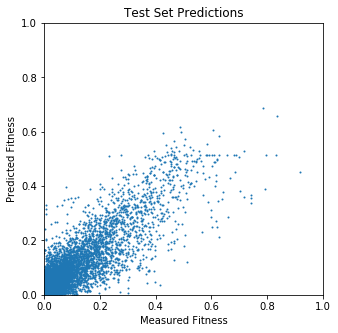

In [28]:
from scipy.stats import pearsonr

predictions = []
actuals = []
loss_total = []
net.eval()
for x_batch, y_batch in tqdm(test_loader):
    pred = net.forward(x_batch)
    loss = loss_fn(pred, y_batch)
    loss_total.append(loss)
    actuals.append(y_batch)
    predictions.append(pred)

loss_total = [i.unsqueeze(0) for i in loss_total]
loss_total = torch.cat(loss_total)
predictions = torch.cat(predictions)
actuals = torch.cat(actuals)

r_value, t_value = pearsonr(predictions.detach().numpy().reshape(-1), actuals.numpy().reshape(-1))

print(f'Test set MSE = {round(loss_total.mean().item(), 3)}')
print(f'Pearson r score = {round(r_value,3)}')

plt.figure(figsize=(5,5))
plt.scatter(actuals,predictions.detach(), s = 1)
plt.title('Test Set Predictions')
plt.xlabel('Measured Fitness')
plt.ylabel('Predicted Fitness')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [32]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Linear(2,4*20)
    def forward(self):
        x = torch.randn(2).unsqueeze(0)
        x = self.layer1(x)
        x = x.reshape(4,20)
        x = torch.softmax(x,dim=1)
        x = x.reshape(-1,)
        return x
gen = Generator()
gen()

tensor([0.0207, 0.0692, 0.0175, 0.0125, 0.0212, 0.0086, 0.0341, 0.1407, 0.0873,
        0.0055, 0.0284, 0.0463, 0.0196, 0.1382, 0.0339, 0.1009, 0.0029, 0.0567,
        0.0040, 0.1517, 0.0553, 0.0285, 0.0170, 0.0058, 0.0477, 0.2078, 0.0415,
        0.0325, 0.0152, 0.0352, 0.0167, 0.0386, 0.0137, 0.0177, 0.0893, 0.0787,
        0.0670, 0.0119, 0.1445, 0.0353, 0.0103, 0.0284, 0.0230, 0.0148, 0.0189,
        0.0105, 0.0275, 0.0640, 0.0271, 0.0837, 0.0108, 0.0867, 0.0191, 0.0156,
        0.0255, 0.0749, 0.1143, 0.1268, 0.0633, 0.1549, 0.0129, 0.0071, 0.1777,
        0.0169, 0.0374, 0.0502, 0.0293, 0.0160, 0.0320, 0.0423, 0.0427, 0.0176,
        0.1010, 0.1600, 0.0047, 0.0306, 0.0331, 0.1347, 0.0384, 0.0153],
       grad_fn=<ViewBackward>)

In [33]:
def rev_ohe(x):
    aas = dict(zip(range(20), 
        ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'V', 'W', 'Y']))
    # split into chunks of 20
    letters = []
    for i in range(int(len(x)/20)):        
        pos = x[i*20:(i*20)+20]
        idx = np.argmax(pos)
        aa = aas[idx]
        letters.append(aa)
    return letters
        
    
print(rev_ohe(sequences_ohe.loc[0,:]))
print(rev_ohe(gen().detach().numpy()))

['V', 'D', 'G', 'V']
['V', 'H', 'F', 'W']


In [34]:
for i in range(10):
    new_seq_tensor = gen()
    fitness = net(new_seq_tensor)
    new_seq_string = rev_ohe(new_seq_tensor.detach().numpy())
    print(f'Mutant: {new_seq_string} \t Predicted Fitness: {round(fitness.detach().item(), 4)}')

Mutant: ['V', 'H', 'I', 'W'] 	 Predicted Fitness: 0.0002
Mutant: ['Q', 'G', 'S', 'V'] 	 Predicted Fitness: 0.0001
Mutant: ['Q', 'T', 'H', 'H'] 	 Predicted Fitness: 0.0001
Mutant: ['V', 'H', 'F', 'W'] 	 Predicted Fitness: 0.0002
Mutant: ['Q', 'T', 'F', 'G'] 	 Predicted Fitness: 0.0002
Mutant: ['V', 'H', 'F', 'W'] 	 Predicted Fitness: 0.0003
Mutant: ['T', 'H', 'F', 'W'] 	 Predicted Fitness: 0.0003
Mutant: ['I', 'H', 'N', 'P'] 	 Predicted Fitness: 0.0002
Mutant: ['V', 'H', 'F', 'W'] 	 Predicted Fitness: 0.0003
Mutant: ['Q', 'T', 'S', 'H'] 	 Predicted Fitness: 0.0001


100%|██████████| 1000000/1000000 [17:11<00:00, 969.82it/s]


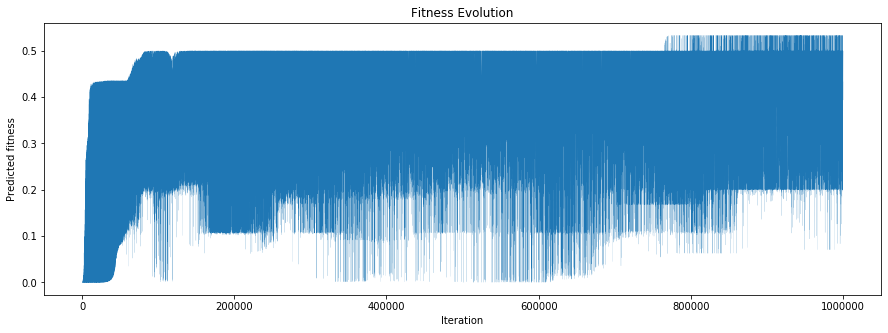

In [35]:
opt_gen = torch.optim.Adam(gen.parameters(), lr = 1e-4)
fitness_record = []

for i in tqdm(range(int(1e6))):
    new_seq_tensor = gen()
    fitness = net(new_seq_tensor)
    loss = 1- fitness
    loss.backward()
    opt_gen.step()
    opt_gen.zero_grad
    fitness_record.append(fitness.detach().item())
    
    
plt.figure(figsize = (15,5))
plt.plot(fitness_record, lw = 0.1)
plt.xlabel('Iteration')
plt.ylabel('Predicted fitness')
plt.title('Fitness Evolution')
plt.show()

In [36]:
for i in range(10):
    new_seq_tensor = gen()
    fitness = net(new_seq_tensor)
    new_seq_string = rev_ohe(new_seq_tensor.detach().numpy())
    print(f'Mutant: {new_seq_string} \t Predicted Fitness: {round(fitness.detach().item(), 4)}')

Mutant: ['F', 'Y', 'G', 'C'] 	 Predicted Fitness: 0.4334
Mutant: ['F', 'Y', 'G', 'M'] 	 Predicted Fitness: 0.3942
Mutant: ['F', 'Y', 'G', 'C'] 	 Predicted Fitness: 0.4334
Mutant: ['L', 'W', 'C', 'A'] 	 Predicted Fitness: 0.4999
Mutant: ['F', 'W', 'G', 'C'] 	 Predicted Fitness: 0.3939
Mutant: ['L', 'W', 'C', 'A'] 	 Predicted Fitness: 0.4999
Mutant: ['I', 'Y', 'G', 'M'] 	 Predicted Fitness: 0.4242
Mutant: ['F', 'Y', 'G', 'C'] 	 Predicted Fitness: 0.4334
Mutant: ['L', 'W', 'C', 'A'] 	 Predicted Fitness: 0.4999
Mutant: ['I', 'Y', 'G', 'C'] 	 Predicted Fitness: 0.4314


# Visualisation fails

In [15]:
import umap
reducer = umap.UMAP()
sequences_ohe_sample = sequences_ohe.sample(50_000)
reducer.fit(sequences_ohe_sample)
embedding = reducer.transform(sequences_ohe)
print(embedding[0:10])

[[0.9963133  1.7918949 ]
 [0.5707638  1.2627143 ]
 [0.19557044 1.3382448 ]
 [0.6048534  1.6919922 ]
 [0.51296794 0.79111534]
 [0.74803346 0.92962044]
 [0.36181492 1.6776781 ]
 [0.04872159 1.2152152 ]
 [0.5142567  1.1889491 ]
 [0.909466   1.0199852 ]]


<Figure size 432x288 with 0 Axes>

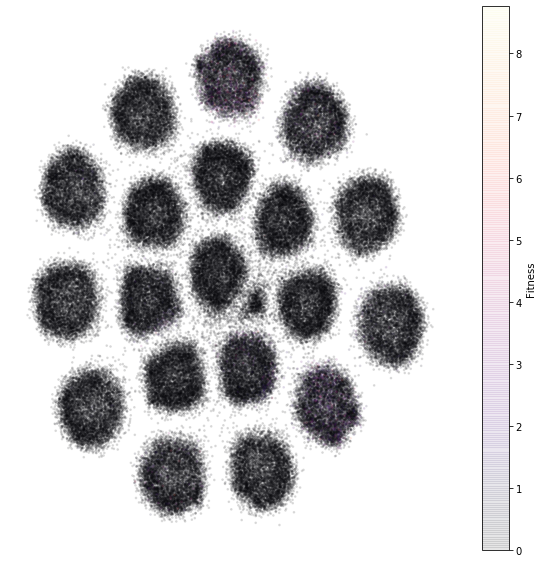

In [26]:
plt.set_cmap('magma')
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], c=df['Fitness'], alpha = 0.1, s = 3)
plt.axis('off')
plt.colorbar(label = 'Fitness')
plt.show()

100%|██████████| 7469/7469 [00:12<00:00, 587.36it/s]


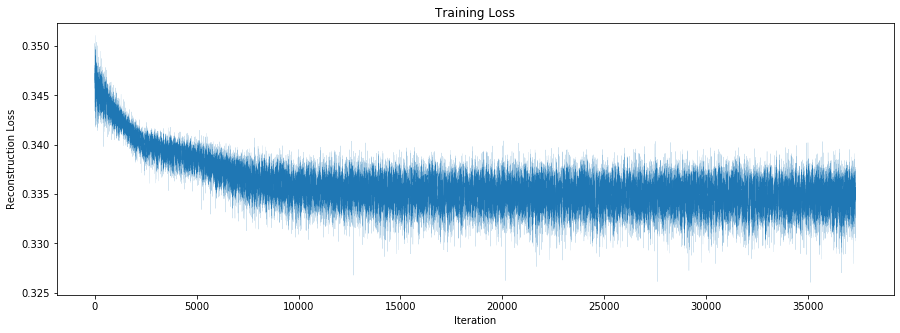

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.enc1 = nn.Linear(80,8)
        self.enc2 = nn.Linear(8,2)
        self.dec1 = nn.Linear(2,8)
        self.dec2 = nn.Linear(8,80)
        self.leakyRelu = nn.LeakyReLU()
    def encode(self, x):
        batch_size = x.shape[0]
        x = self.enc1(x)
        x = self.leakyRelu(x)
        x = self.enc2(x)
        x = self.leakyRelu(x)
        return x
    def decode(self, z):
        batch_size = z.shape[0]
        z = self.dec1(z)
        z = self.leakyRelu(z)
        z = self.dec2(z)
        z = z.reshape(batch_size, 4,20)
        z = torch.softmax(z, dim=1)
        z = z.reshape(batch_size,-1,)
        return z

autoencoder = AutoEncoder()


ae_opt = torch.optim.Adam(autoencoder.parameters(), lr = 1e-4)
ae_loss_fn = nn.BCELoss()

training_loss_record = []

for epoch in range(1,6):
    for x_batch, _ in tqdm(train_loader):
        z = autoencoder.encode(x_batch.float())
        x_pred = autoencoder.decode(z) 
        loss = ae_loss_fn(x_pred, x_batch)
        loss.backward()
        training_loss_record.append(loss.item())
        ae_opt.step()
        ae_opt.zero_grad()
        
plt.figure(figsize=(15,5))
plt.plot(training_loss_record, lw = 0.1)
plt.xlabel('Iteration')
plt.ylabel('Reconstruction Loss')
plt.title('Training Loss')
plt.show()

In [28]:
def MutationsToFitnessLandscape(ohe):
    ## takes a one hot encoded sequence (numpy)
    ohe = torch.from_numpy(ohe).float()
    xy = autoencoder.encode(ohe).detach().numpy()
    z = net(ohe).detach().numpy()
    xyz = pd.Series(np.concatenate([xy,z]), index = ['x','y','z'])
    return xyz


fitness_landscape = pd.DataFrame(list(map(MutationsToFitnessLandscape, sequences_ohe.values)))
fitness_landscape.head()

,x,y,z
0,2.298183,2.253352,0.101482
1,2.665286,2.403356,0.041981
2,3.465516,2.441328,0.046089
3,3.518988,2.825308,0.009201
4,2.768863,2.520175,0.037029


In [29]:
fitness_landscape.to_csv('fitness_landscape.csv')

<Figure size 432x288 with 0 Axes>

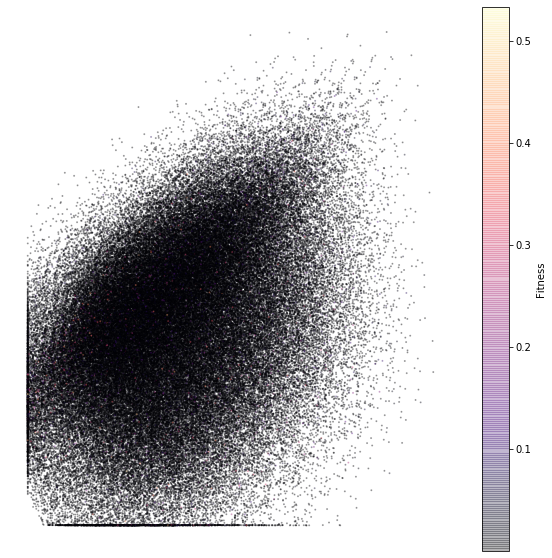

In [30]:
plt.set_cmap('magma')
plt.figure(figsize=(10,10))
plt.scatter(fitness_landscape['x'], fitness_landscape['y'], c=fitness_landscape['z'], alpha = 0.3, s = 1)
plt.axis('off')
plt.colorbar(label = 'Fitness')
plt.show()